### Context

##### DRS bank is facing challenging times. Their NPAs (Non-Performing Assets) has been on a rise recently and a large part of these are due to the loans given to individual customers(borrowers). Chief Risk Officer of the bank decides to put in a scientifically robust framework for approval of loans to individual customers to minimize the risk of loans converting into NPAs and initiates a project for the data science team at the bank. You, as a senior member of the team, are assigned this project.

### Objective
#### To identify the criteria to approve loans for an individual customer such that the likelihood of the loan delinquency is minimized

### Key questions to be answered
##### What are the factors that drive the behavior of loan delinquency?

### Dataset
- ID: Customer ID
- isDelinquent : indicates whether the customer is delinquent or not (1 => Yes, 0 => No)
- term: Loan term in months
- gender: Gender of the borrower
- age: Age of the borrower
- purpose: Purpose of Loan
- home_ownership: Status of borrower's home
- FICO: FICO (i.e. the bureau score) of the borrower

### Domain Information
- Transactor – A person who pays his due amount balance full and on time.
- Revolver – A person who pays the minimum due amount but keeps revolving his balance and does not pay the full amount.
- Delinquent - Delinquency means that you are behind on payments, a person who fails to pay even the minimum due amount.
- Defaulter – Once you are delinquent for a certain period your lender will declare you to be in the default stage.
- Risk Analytics – A wide domain in the financial and banking industry, basically analyzing the risk of the customer.

### import the necessary packages

In [94]:
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd



import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows",200)

from sklearn.model_selection import train_test_split

# to build decision tree classifier model
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# to tune different models
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    #plot_confusion_matrix,
    make_scorer
)




In [95]:
data = pd.read_csv('Loan_Delinquent_Dataset.csv')

In [96]:
df = data.copy()

In [97]:
df.head()

,ID,isDelinquent,term,gender,purpose,home_ownership,age,FICO
0,1,1,36 months,Female,House,Mortgage,>25,300-500
1,2,0,36 months,Female,House,Rent,20-25,>500
2,3,1,36 months,Female,House,Rent,>25,300-500
3,4,1,36 months,Female,Car,Mortgage,>25,300-500
4,5,1,36 months,Female,House,Rent,>25,300-500


In [98]:
df.tail()

,ID,isDelinquent,term,gender,purpose,home_ownership,age,FICO
11543,11544,0,60 months,Male,other,Mortgage,>25,300-500
11544,11545,1,36 months,Male,House,Rent,20-25,300-500
11545,11546,0,36 months,Female,Personal,Mortgage,20-25,>500
11546,11547,1,36 months,Female,House,Rent,20-25,300-500
11547,11548,1,36 months,Male,Personal,Mortgage,20-25,300-500


In [99]:
df.isnull().sum()

ID                0
isDelinquent      0
term              0
gender            0
purpose           0
home_ownership    0
age               0
FICO              0
dtype: int64

In [100]:
df.duplicated().sum()

0

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11548 entries, 0 to 11547
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              11548 non-null  int64 
 1   isDelinquent    11548 non-null  int64 
 2   term            11548 non-null  object
 3   gender          11548 non-null  object
 4   purpose         11548 non-null  object
 5   home_ownership  11548 non-null  object
 6   age             11548 non-null  object
 7   FICO            11548 non-null  object
dtypes: int64(2), object(6)
memory usage: 721.9+ KB


In [102]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,11548.0,5774.500000,3333.764789,1.0,2887.75,5774.5,8661.25,11548.0
isDelinquent,11548.0,0.668601,0.470737,0.0,0.00,1.0,1.00,1.0


In [103]:
df.shape

(11548, 8)

In [104]:
df.drop(["ID"], axis= 1, inplace=True)

In [105]:
df.head()

,isDelinquent,term,gender,purpose,home_ownership,age,FICO
0,1,36 months,Female,House,Mortgage,>25,300-500
1,0,36 months,Female,House,Rent,20-25,>500
2,1,36 months,Female,House,Rent,>25,300-500
3,1,36 months,Female,Car,Mortgage,>25,300-500
4,1,36 months,Female,House,Rent,>25,300-500


#### Model building approach

- Data Preparation
- Partition the data in train and test data
- Built CART model on the train model
- Tune the model and prune the tree, if required


#### Split data

In [106]:
X = df.drop(['isDelinquent'], axis=1)
y = df['isDelinquent']

In [107]:
X= pd.get_dummies(X, drop_first=True)
X.head()

,term_60 months,gender_Male,purpose_House,purpose_Medical,purpose_Other,purpose_Personal,purpose_Wedding,purpose_other,home_ownership_Own,home_ownership_Rent,age_>25,FICO_>500
0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,1,0,1
2,0,0,1,0,0,0,0,0,0,1,1,0
3,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0,0,1,1,0


In [108]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 1)

### Build Decision Tree Model

##### Model evaluation criterion

- Predicting a customer will not be behind on payments (Non-Delinquent) but in reality the customer would be behind on payments.

- Predicting a customer will be behind on payments (Delinquent) but in reality the customer would not be behind on payments (Non-Delinquent).

##### Which case is more important?

recall should be maximized, the greater the recall higher the chances of minimizing the false negatives.

##### First, let's create functions to calculate different metrics and confusion matrix so that we don't have to use the same code repeatedly for each model.
- The model_performance_classification_sklearn function will be used to check the model performance of models.
- The make_confusion_matrix function will be used to plot confusion matrix

In [109]:
# defining a function to compute different metrics to check model performace of a classification model build using decision tree model
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute metrics to check classification model performance 
    model: classifier
    predictors: independent variables
    target: dependent variables
    """
    pred = model.predict(predictors)
    acc = accuracy_score(target, pred)
    recall = recall_score(target, pred)
    precision = precision_score(target, pred)
    f1 = f1_score(target, pred)
    df_perf = pd.DataFrame({"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1}, index =[0])
    return df_perf

In [130]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion matrix with performance
    model: classifier
    predictors: independent variables
    target: dependent variables
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray([
        ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item/cm.flatten().sum())]
        for item in cm.flatten()
    ]).reshape(2,2)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Build Decision Tree Model

In [131]:
model = DecisionTreeClassifier(criterion ="gini", random_state=1)
model.fit(X_train, y_train)
#model.get_params()
#model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=1)

#### Checking model performance on training set

In [132]:
decision_tree_perf_train = model_performance_classification_sklearn(model, X_train, y_train)
decision_tree_perf_train

,Accuracy,Recall,Precision,F1
0,0.852283,0.906571,0.878201,0.89216


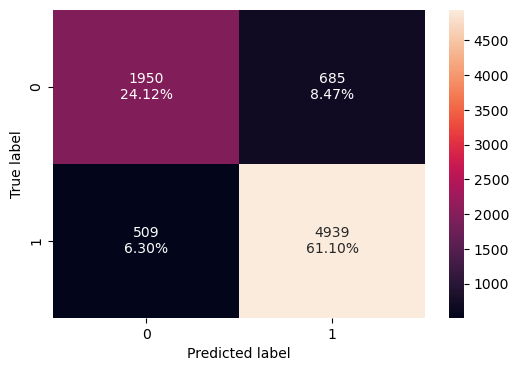

In [133]:
confusion_matrix_sklearn(model, X_train, y_train)

#### Checking model performance on test set

In [135]:
decision_tree_perf_test = model_performance_classification_sklearn(model, X_test, y_test)
decision_tree_perf_test

,Accuracy,Recall,Precision,F1
0,0.847042,0.893973,0.875485,0.884632


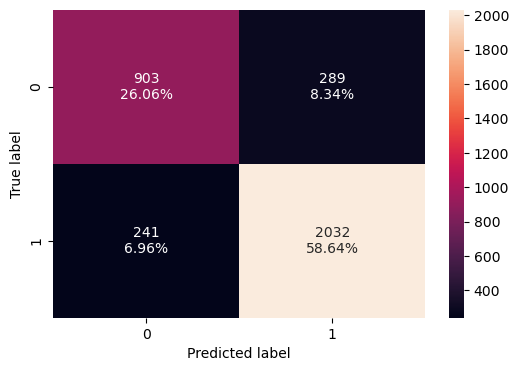

In [136]:
confusion_matrix_sklearn(model, X_test, y_test)

#### Visualizing Decison Tree

In [137]:
column_names = list(X.columns)
feature_names = column_names
feature_names

['term_60 months',
 'gender_Male',
 'purpose_House',
 'purpose_Medical',
 'purpose_Other',
 'purpose_Personal',
 'purpose_Wedding',
 'purpose_other',
 'home_ownership_Own',
 'home_ownership_Rent',
 'age_>25',
 'FICO_>500']

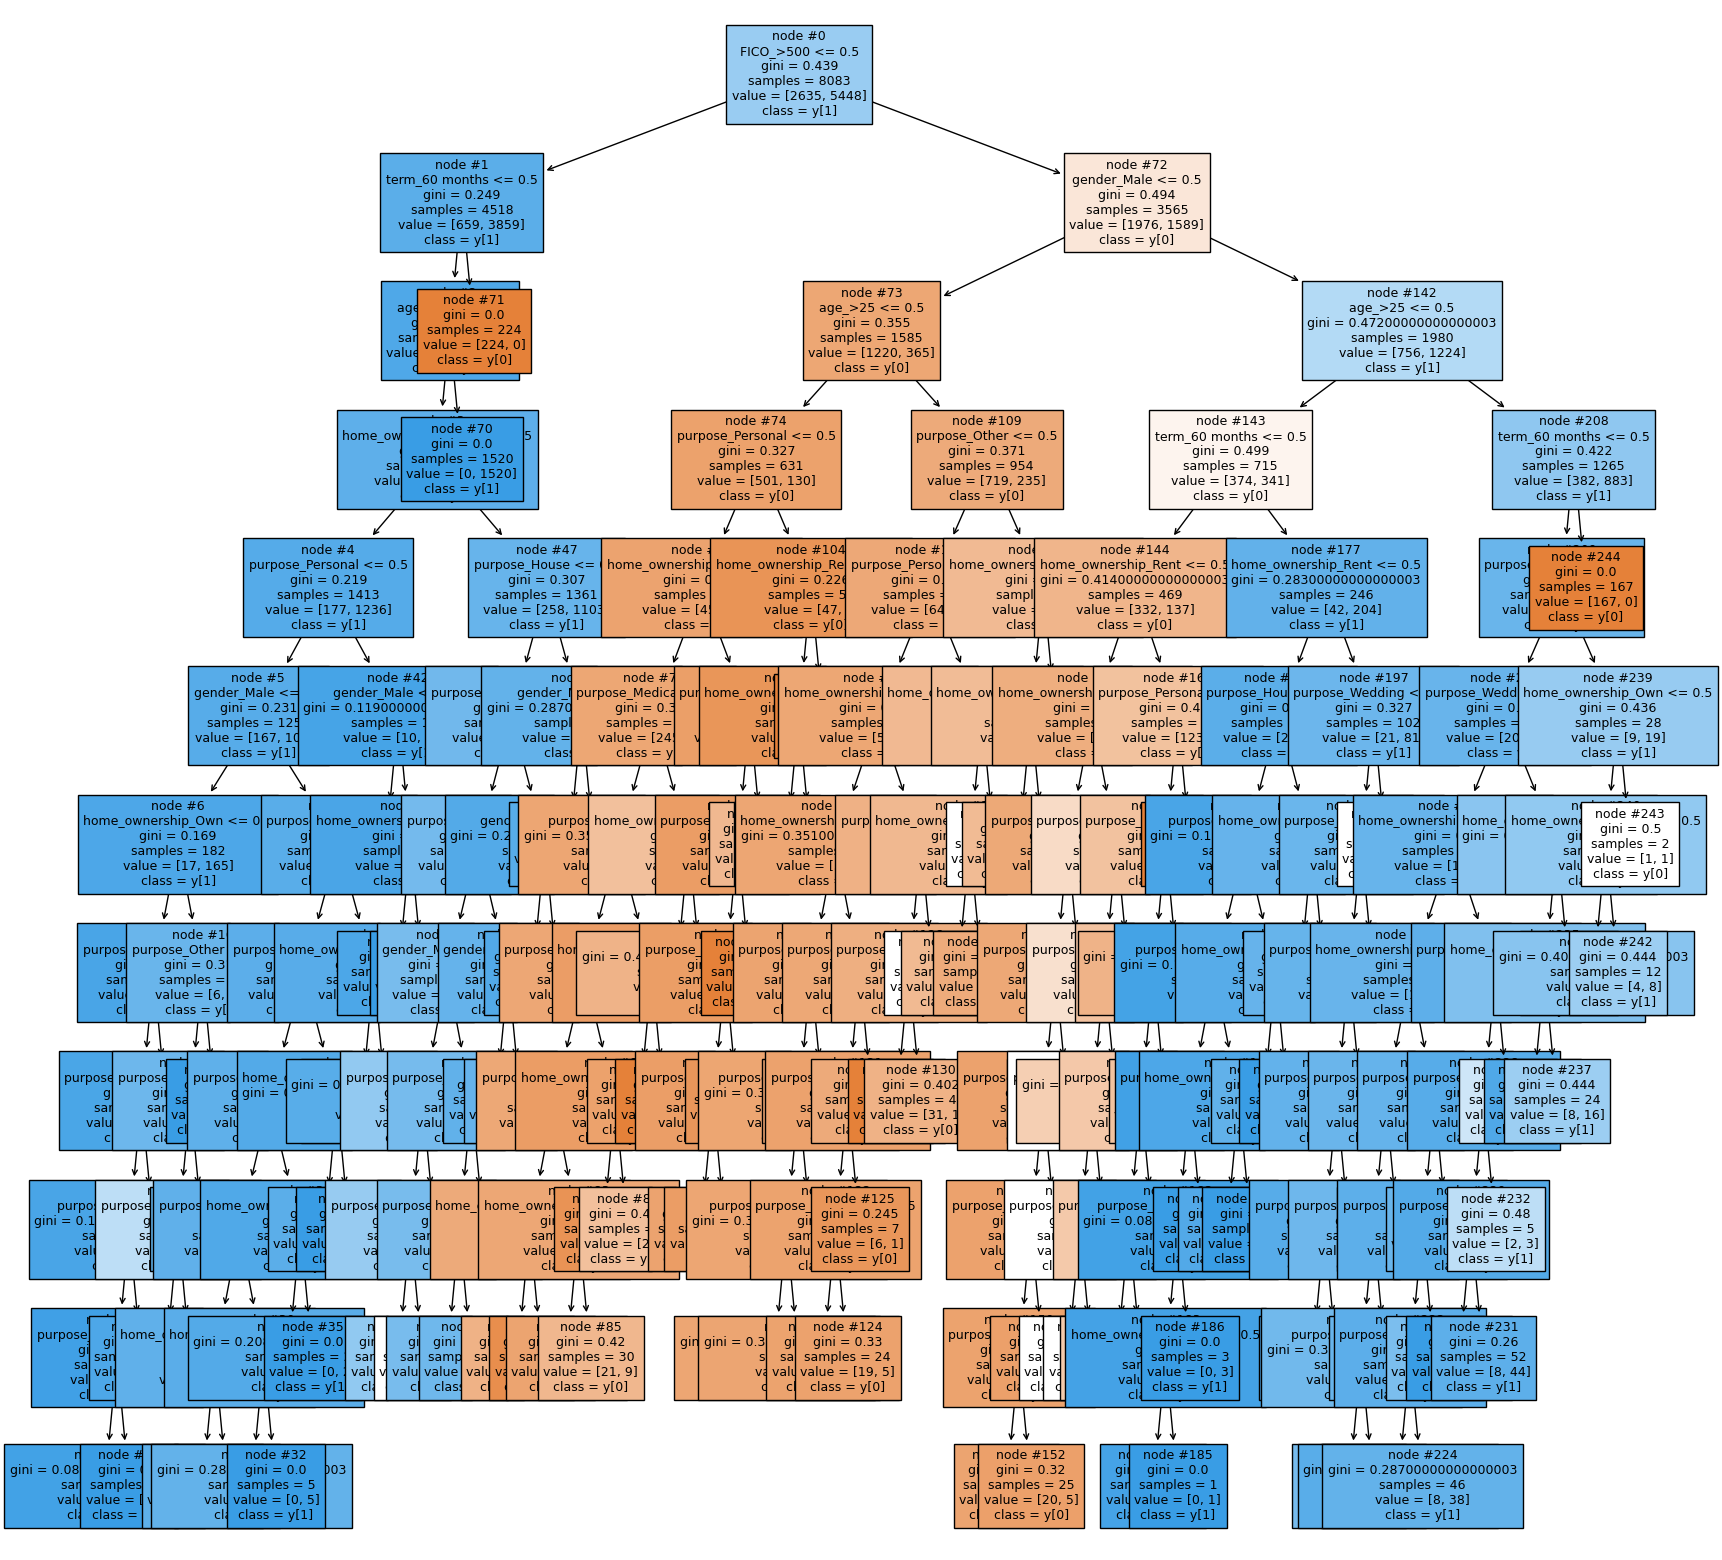

In [139]:
plt.figure(figsize =(20,20))
out = tree.plot_tree(model, feature_names =feature_names, filled= True, fontsize = 9,node_ids = True, class_names= True )
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

In [142]:
# text report showing the rules of a decision tree

print(tree.export_text(model, feature_names = feature_names, show_weights=True))

|--- FICO_>500 <= 0.50
|   |--- term_60 months <= 0.50
|   |   |--- age_>25 <= 0.50
|   |   |   |--- home_ownership_Rent <= 0.50
|   |   |   |   |--- purpose_Personal <= 0.50
|   |   |   |   |   |--- gender_Male <= 0.50
|   |   |   |   |   |   |--- home_ownership_Own <= 0.50
|   |   |   |   |   |   |   |--- purpose_Other <= 0.50
|   |   |   |   |   |   |   |   |--- purpose_Medical <= 0.50
|   |   |   |   |   |   |   |   |   |--- purpose_House <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- purpose_Wedding <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- weights: [1.00, 21.00] class: 1
|   |   |   |   |   |   |   |   |   |   |--- purpose_Wedding >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- weights: [0.00, 9.00] class: 1
|   |   |   |   |   |   |   |   |   |--- purpose_House >  0.50
|   |   |   |   |   |   |   |   |   |   |--- weights: [9.00, 91.00] class: 1
|   |   |   |   |   |   |   |   |--- purpose_Medical >  0.50
|   |   |   |   |   |   |   |   |   |--- weig

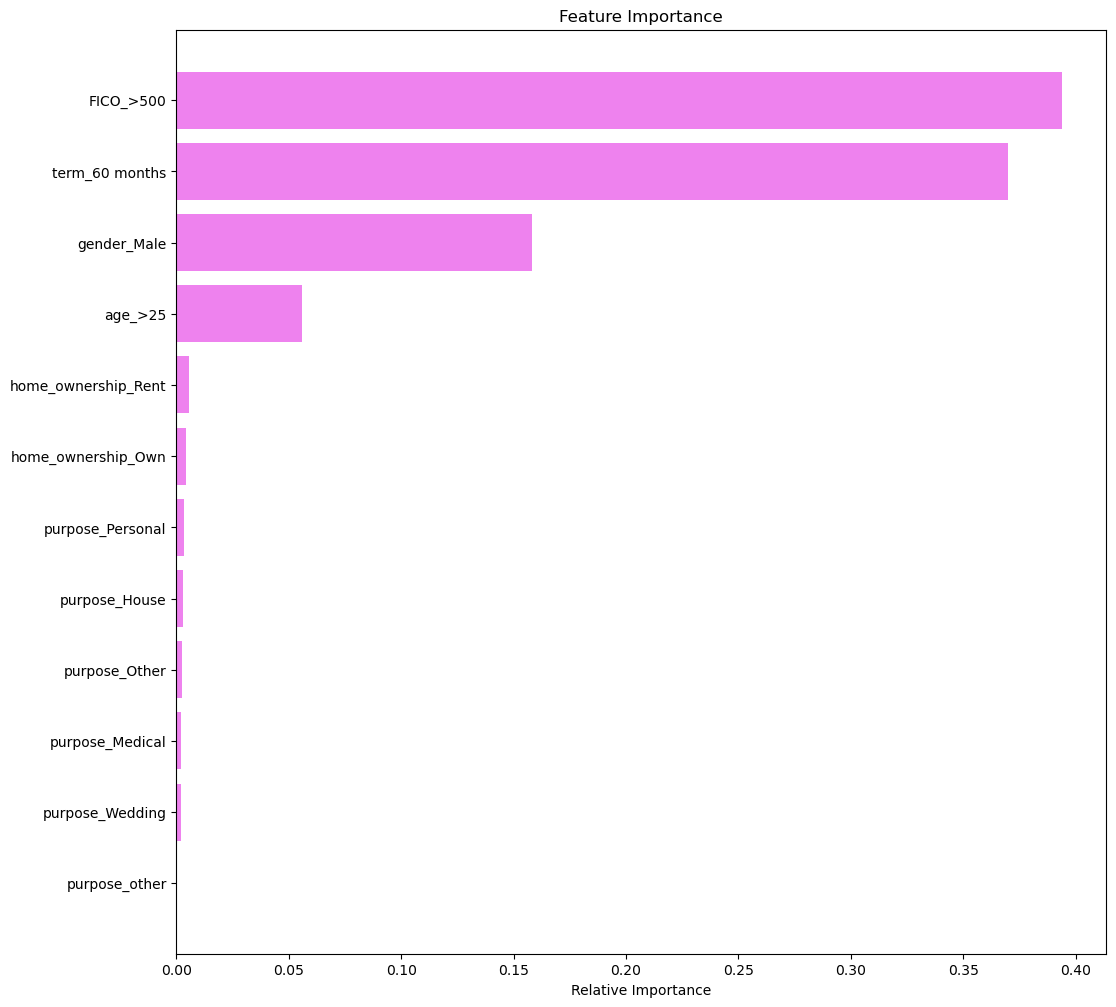

In [143]:
importances =  model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12,12))
plt.title("Feature Importance")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

#### Using GridSearchCV for hyperparameter tuning of our tree model

In [145]:
estimator = DecisionTreeClassifier(random_state=1)
parameters = {
    "max_depth": [np.arange(2,50, 5), None],
    "criterion": ["entropy","gini"],
    "splitter": ["best","random"],
    "min_impurity_decrease": [0.000001, 0.00001, 0.0001]
}

acc_score = make_scorer(recall_score)
grid_obj = GridSearchCV(estimator, parameters, scoring = acc_score , cv=5)
grid_obj = grid_obj.fit(X_train, y_train)
estimator = grid_obj.best_estimator_
estimator.fit(X_train, y_train)

DecisionTreeClassifier(min_impurity_decrease=0.0001, random_state=1)

#### Checking performance on training set

In [147]:
decision_tree_tune_perf_train = model_performance_classification_sklearn(estimator, X_train, y_train)
decision_tree_tune_perf_train

,Accuracy,Recall,Precision,F1
0,0.852283,0.907856,0.877261,0.892297


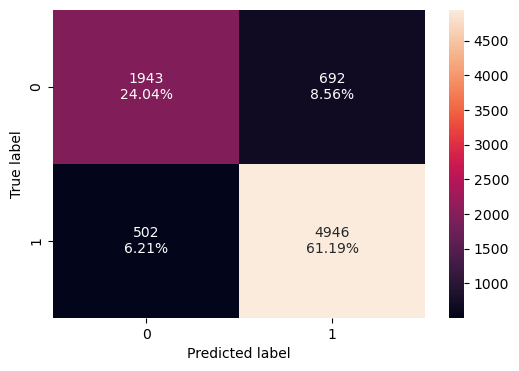

In [148]:
confusion_matrix_sklearn(estimator, X_train, y_train)

#### Checking the performance on the test set

In [149]:
decision_tree_tune_perf_test = model_performance_classification_sklearn(estimator, X_test, y_test)
decision_tree_tune_perf_test

,Accuracy,Recall,Precision,F1
0,0.847908,0.896172,0.875,0.88546


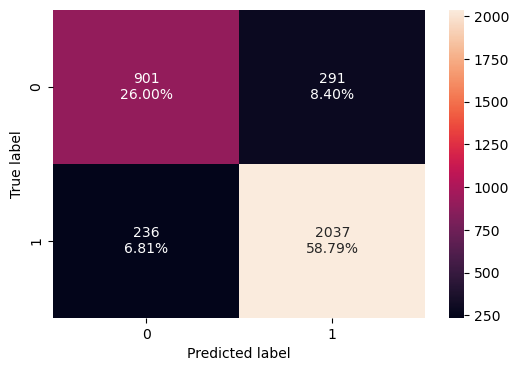

In [150]:
confusion_matrix_sklearn(estimator, X_test, y_test)

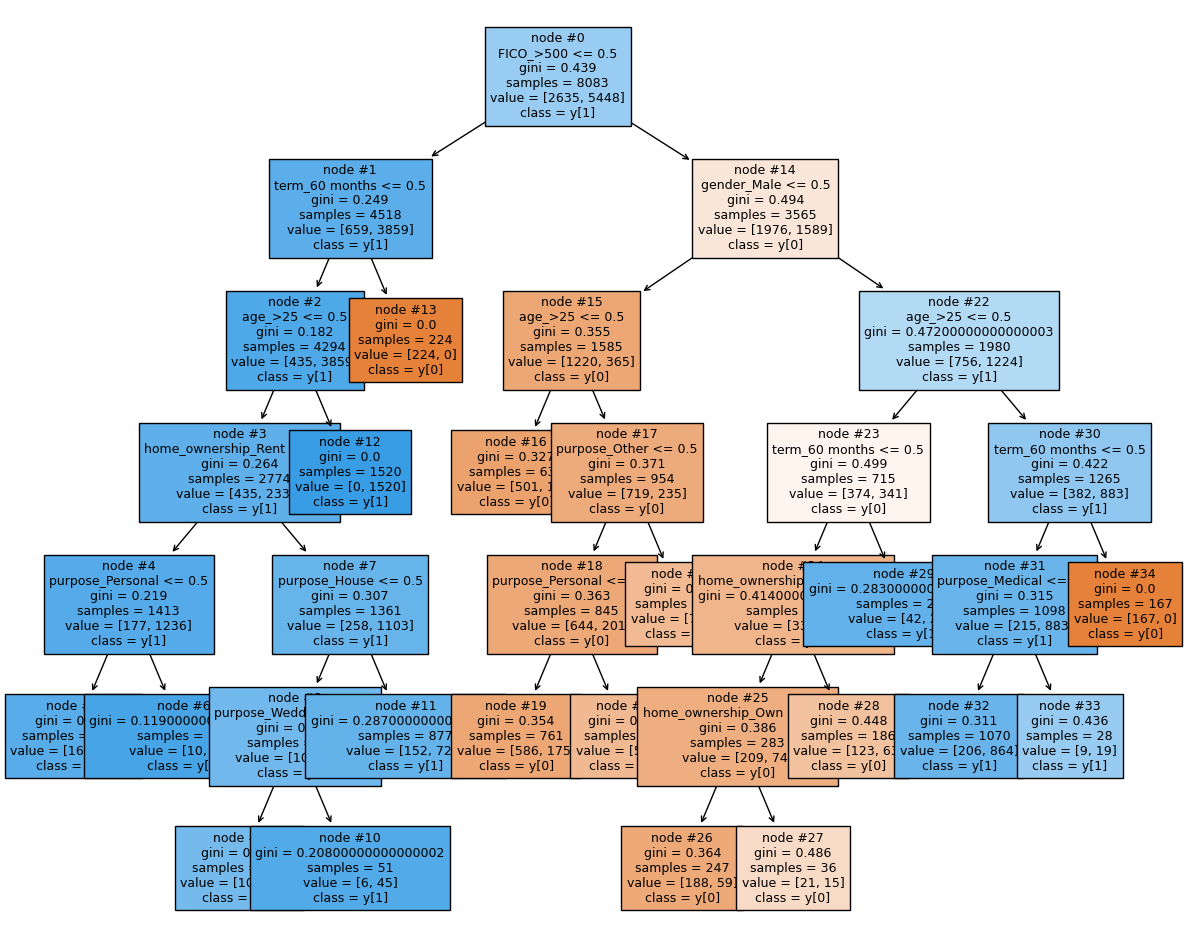

In [151]:
plt.figure(figsize=(15,12))
tree.plot_tree(estimator, feature_names = feature_names, filled = True, fontsize=9, node_ids=True, class_names = True)
plt.show()

#### Cost Complexity Prunning

In [153]:
clf = DecisionTreeClassifier(random_state=1)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [154]:
pd.DataFrame(path)

,ccp_alphas,impurities
0,0.000000e+00,0.230660
1,0.000000e+00,0.230660
2,4.998644e-08,0.230660
3,7.930541e-08,0.230660
4,1.155149e-07,0.230660
5,1.881954e-07,0.230660
6,3.564890e-07,0.230661
7,4.474709e-07,0.230661
8,7.111129e-07,0.230663
9,7.234880e-07,0.230663


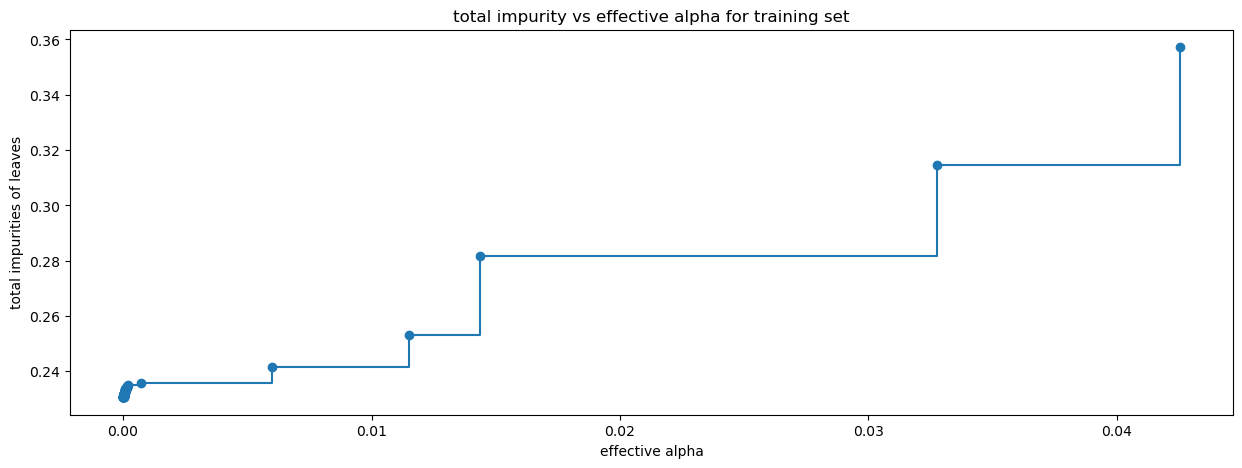

In [155]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurities of leaves")
ax.set_title("total impurity vs effective alpha for training set")
plt.show()

In [156]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.0822427420013363


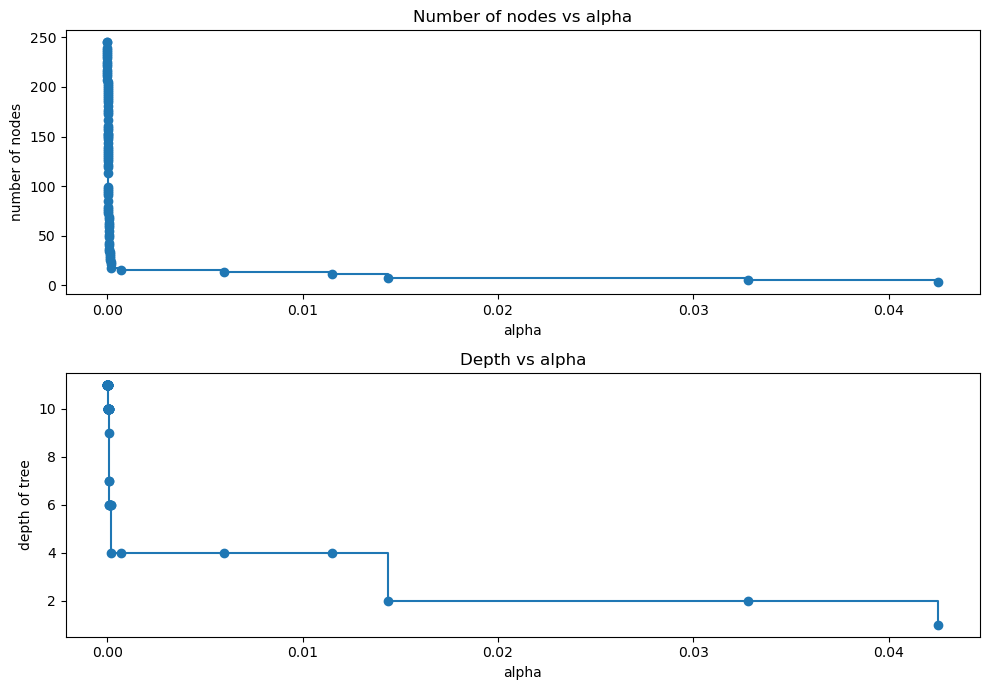

In [157]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

#### Recall vs alpha for training and testing sets

In [158]:
recall_train = []
for clf in clfs:
    pred_train = clf.predict(X_train)
    values_train = recall_score(y_train, pred_train)
    recall_train.append(values_train)

In [159]:
recall_test = []
for clf in clfs:
    pred_test = clf.predict(X_test)
    value_test = recall_score(y_test, pred_test)
    recall_test.append(value_test)

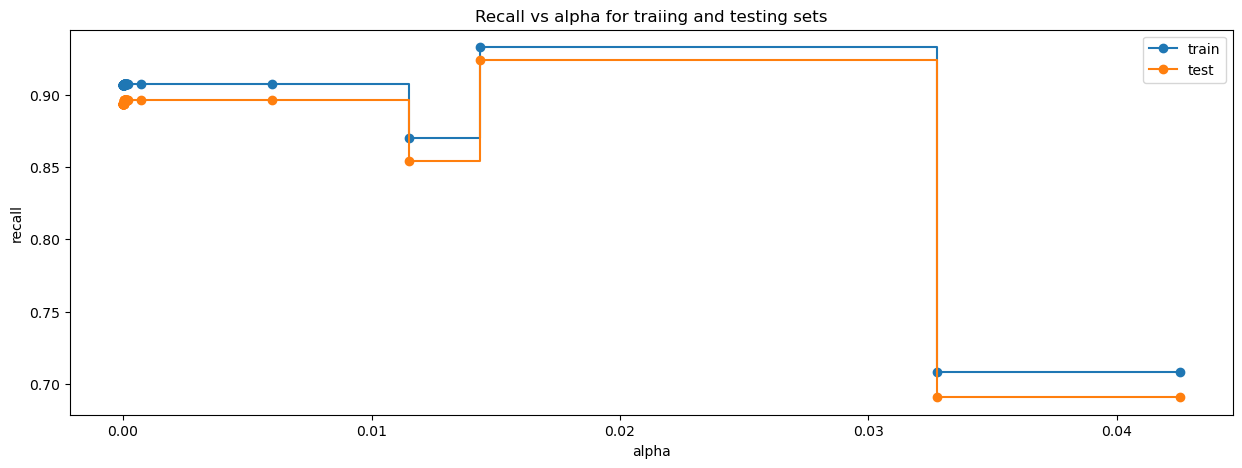

In [160]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xlabel("alpha")
ax.set_ylabel("recall")
ax.set_title("Recall vs alpha for traiing and testing sets")
ax.plot(ccp_alphas, recall_train, marker="o", label="train",drawstyle= "steps-post")
ax.plot(ccp_alphas, recall_test, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [161]:
# creating the model where we get highest train and test recall
index_best_model = np.argmax(recall_test)
best_model = clfs[index_best_model]
print(best_model)

DecisionTreeClassifier(ccp_alpha=0.0143604472570548, random_state=1)


In [162]:
decision_tree_postpruned_perf_train = model_performance_classification_sklearn(
    best_model, X_train, y_train
)
decision_tree_postpruned_perf_train

,Accuracy,Recall,Precision,F1
0,0.807497,0.933003,0.810169,0.867258


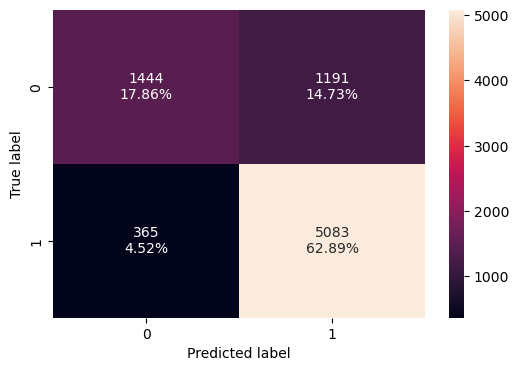

In [163]:

confusion_matrix_sklearn(best_model, X_train, y_train)

### Checking model performance on test set

In [164]:
decision_tree_postpruned_perf_test = model_performance_classification_sklearn(
    best_model, X_test, y_test
)
decision_tree_postpruned_perf_test

,Accuracy,Recall,Precision,F1
0,0.804329,0.923889,0.806142,0.861009


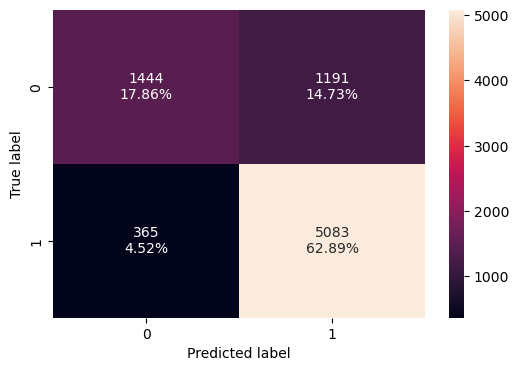

In [165]:
confusion_matrix_sklearn(best_model, X_train, y_train)

#### Visualizing the decision tree

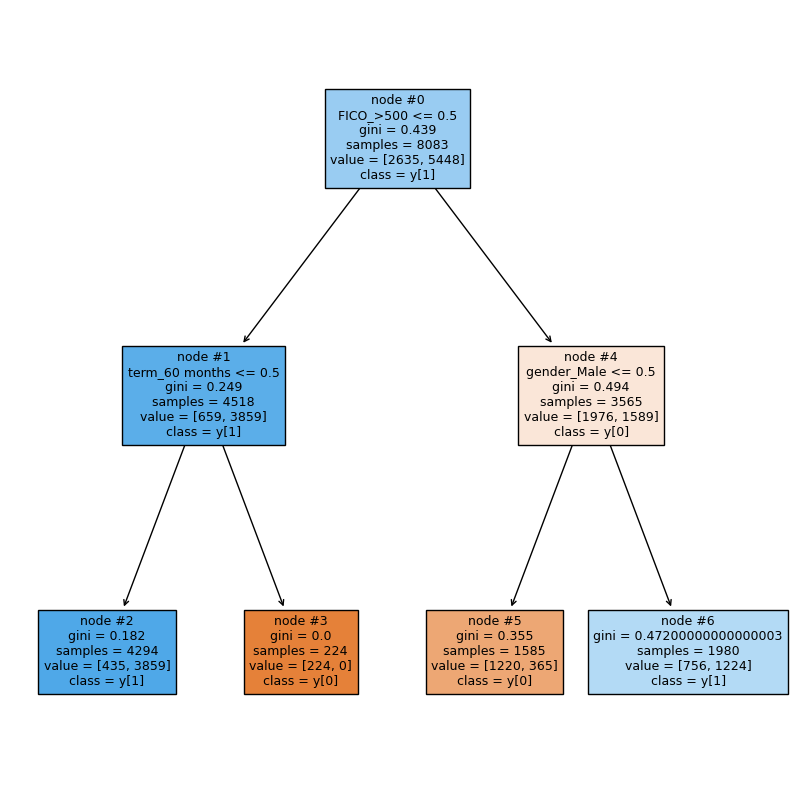

In [167]:
plt.figure(figsize=(10, 10))

out = tree.plot_tree(
    best_model,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=True,
    class_names=True,
)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()
plt.show()

In [ ]:
print(tree.export_text)